In [6]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tikzplotlib
import seaborn as sns

import json
from datetime import datetime

In [3]:
projects_df = pd.read_csv('/root/data/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'])

packages_df = pd.read_csv('/root/data/packages_0_499.csv')
geiger_df = pd.read_csv('/root/data/geiger/geiger_findings_0_499.csv')

vet_df = pd.read_csv('/root/data/linters/vet_findings_0_499.csv')
gosec_df = pd.read_csv('/root/data/linters/gosec_findings_0_499.csv')

grep_df = pd.read_csv('/root/data/linters/grep_findings_0_499.csv')
ast_df = pd.read_csv('/root/data/ast/ast_findings_0_499.csv')
function_df = pd.read_csv('/root/data/ast/functions_0_499.csv')
statement_df = pd.read_csv('/root/data/ast/statements_0_499.csv')

In [4]:
def with_thousands_comma(n):
    return '{:,}'.format(n)

# Figures included in the thesis document

## Chapter 2

## Chapter 3

## Chapter 4

**Distribution of unsafe by token type**

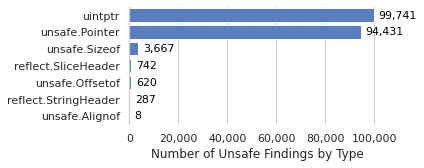

In [7]:
data = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version']).dropna()\
    .loc[:,['package_geiger_unsafe_pointer_sum', 'package_geiger_unsafe_sizeof_sum', 'package_geiger_unsafe_offsetof_sum',
           'package_geiger_unsafe_alignof_sum', 'package_geiger_slice_header_sum', 'package_geiger_string_header_sum',
           'package_geiger_uintptr_sum']]\
    .rename(columns={'package_geiger_unsafe_pointer_sum': 'unsafe.Pointer', 'package_geiger_unsafe_sizeof_sum': 'unsafe.Sizeof',
                    'package_geiger_unsafe_offsetof_sum': 'unsafe.Offsetof', 'package_geiger_unsafe_alignof_sum': 'unsafe.Alignof',
                    'package_geiger_slice_header_sum': 'reflect.SliceHeader', 'package_geiger_string_header_sum': 'reflect.StringHeader',
                    'package_geiger_uintptr_sum': 'uintptr'})\
    .sum()\
    .sort_values(ascending=False)

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 2.5))

# Plot the distribution among types
sns.set_color_codes("muted")
g = sns.barplot(data.values, data.index, color="b")

# Add values next to the bars
for p in ax.patches:
    ax.annotate("{}".format(with_thousands_comma(int(p.get_width()))), (p.get_width(), p.get_y() + p.get_height() / 2.0),
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
#_ = g.set_xlim(0, 120000) #To make space for the annotations

# Add a legend and informative axis label
ax.set(ylabel="", xlabel="Number of Unsafe Findings by Type")
sns.despine(bottom=True)

# Add thousands separator to x axis
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.savefig('/root/data/figures/thesis/chapter4/distribution-unsafe-types.pdf')
plt.show()

**Import depth of unsafe packages**

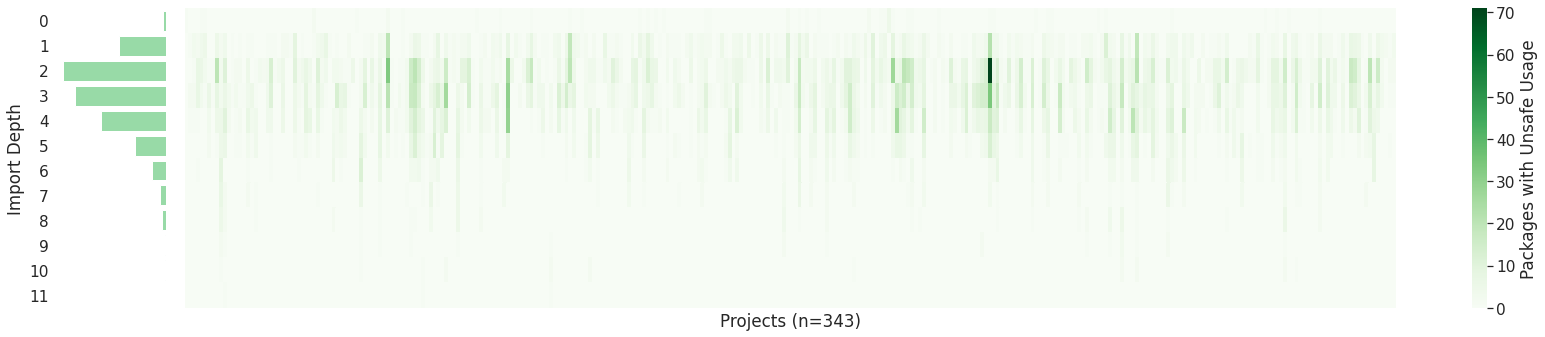

In [10]:
## number of unsafe packages (without std) over hop count

df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby(['project_name', 'package_hop_count'])['package_unsafe_sum'].count()\
    .unstack().fillna(0).T

distribution_df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby('package_hop_count')['package_unsafe_sum'].count().T

sns.set(style="white")
sns.set(font_scale=1.4)

# create plot setup
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(24, 5), gridspec_kw={'width_ratios': [1, 14]})
fig.subplots_adjust(wspace=0)

# plot heatmap
sns.heatmap(df, ax=axs[1], cmap='Greens', cbar_kws={'label': 'Packages with Unsafe Usage'})

# plot distribution
sns.set_color_codes("pastel")
sns.barplot(distribution_df.values, distribution_df.index, orient='h', color="g", ax=axs[0])
axs[0].invert_xaxis()
axs[0].set_facecolor("white")

# labeling
for item in axs[1].get_yticklabels():
    item.set_rotation(0)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set(ylabel="", xlabel="Projects (n={})".format(packages_df['project_name'].nunique()))
axs[0].set(ylabel="Import Depth", xlabel="")
sns.despine(bottom=True, left=True)
axs[0].set_xticks([])

plt.tight_layout()
plt.savefig('/root/data/figures/thesis/chapter4/unsafe-import-depth.pdf', bbox_inches='tight')
plt.show()

**Unsafe packages by registry (N=30)**

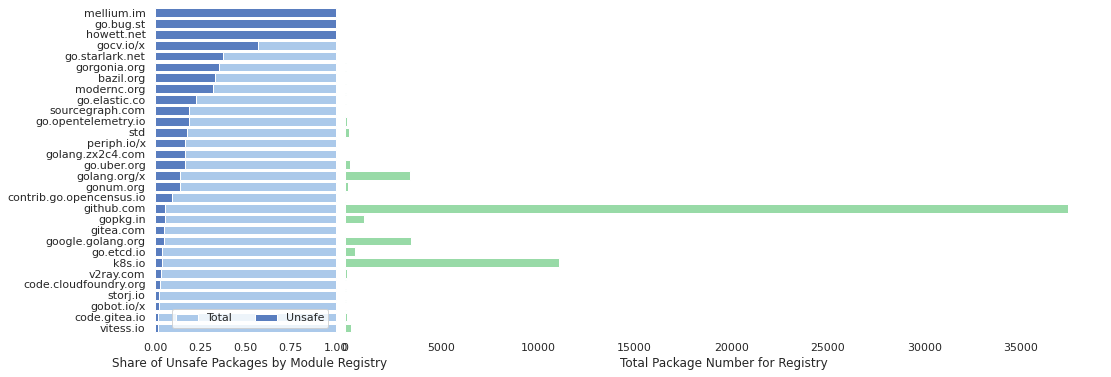

In [12]:
# by far preferred version: combine share and total number of unsafe packages by registry

df = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version']).dropna()\
    .groupby('module_registry')['package_unsafe_sum']\
    .agg(total='count', unsafe=lambda x: np.count_nonzero(x), 
         unsafe_share=lambda x: np.count_nonzero(x)/len(x), one=lambda x: 1)\
    .reset_index()\
    .sort_values(by='unsafe_share', ascending=False)[:30]

sns.set(style="white")

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(17, 6), gridspec_kw={'width_ratios': [1, 4]})
fig.subplots_adjust(wspace=0)

# Plot the total package share (1)
sns.set_color_codes("pastel")
sns.barplot(x="one", y="module_registry", data=df,
            label="Total", color="b", ax=axs[0])

# Plot the unsafe packages share
sns.set_color_codes("muted")
sns.barplot(x="unsafe_share", y="module_registry", data=df,
            label="Unsafe", color="b", ax=axs[0])

# Plot the total package count
sns.set_color_codes("pastel")
sns.barplot(x="total", y="module_registry", data=df,
            label="Total", color="g", ax=axs[1])

# Add a legend and informative axis label
axs[0].legend(ncol=2, loc="lower center", frameon=True)
axs[0].set(ylabel="", xlabel="Share of Unsafe Packages by Module Registry")
axs[1].set(ylabel="", xlabel="Total Package Number for Registry")
sns.despine(left=True, bottom=True)

plt.savefig('/root/data/figures/thesis/chapter4/unsafe-packages-by-registry-n30.pdf')

## Chapter 5

## Chapter 6

## Chapter 7